In [4]:
#Array packages
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nc4

from scipy.stats import kendalltau
import pymannkendall as mk

#plots
import matplotlib.pyplot as plt
import rioxarray as rio
import geopandas as gpd
from shapely.geometry import mapping
import matplotlib.ticker as ticker
import cartopy.feature as cfeature
from matplotlib.patches import Circle
import matplotlib.patches as mpatches
import cartopy.crs as ccrs

#Progress meter
from dask.diagnostics import ProgressBar
from tqdm import tqdm

# Directories
import os
import glob
import dask
#import h5netcdf
import scipy

import os
os.chdir(r"E:\academy\OneDrive - IIT Delhi\3. IIT DELHI\2. Research\1_Streamflow")
print(os.getcwd())

E:\academy\OneDrive - IIT Delhi\3. IIT DELHI\2. Research\1_Streamflow


### 1_Streamflow

In [5]:
data1=sorted(glob.glob(f'3_Data/Data_r/1_ILDAS/*.nc*'))
data = xr.open_mfdataset(data1, combine='by_coords',engine='netcdf4', parallel=True,chunks={'time': 'auto'})
data = data.sel(lon=data['lon'].values[::3],lat=data['lat'].values[::3],time=slice('1975','2022')).compute()


c:\Users\sstar\anaconda3\envs\imed\Lib\site-packages\xarray\core\indexing.py:1436: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


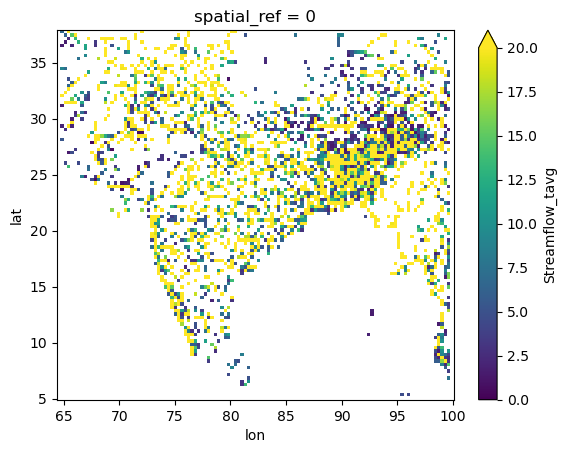

In [14]:
#data['Streamflow_tavg'].mean(dim='time').plot(vmin=0,vmax=20)
cond=np.sum(data['Streamflow_tavg'].values>1,axis=0)>6000
data2=data.where(np.stack([cond] * len(data['time']), axis=0))
data2['Streamflow_tavg'].mean(dim='time').plot(vmin=0,vmax=20)

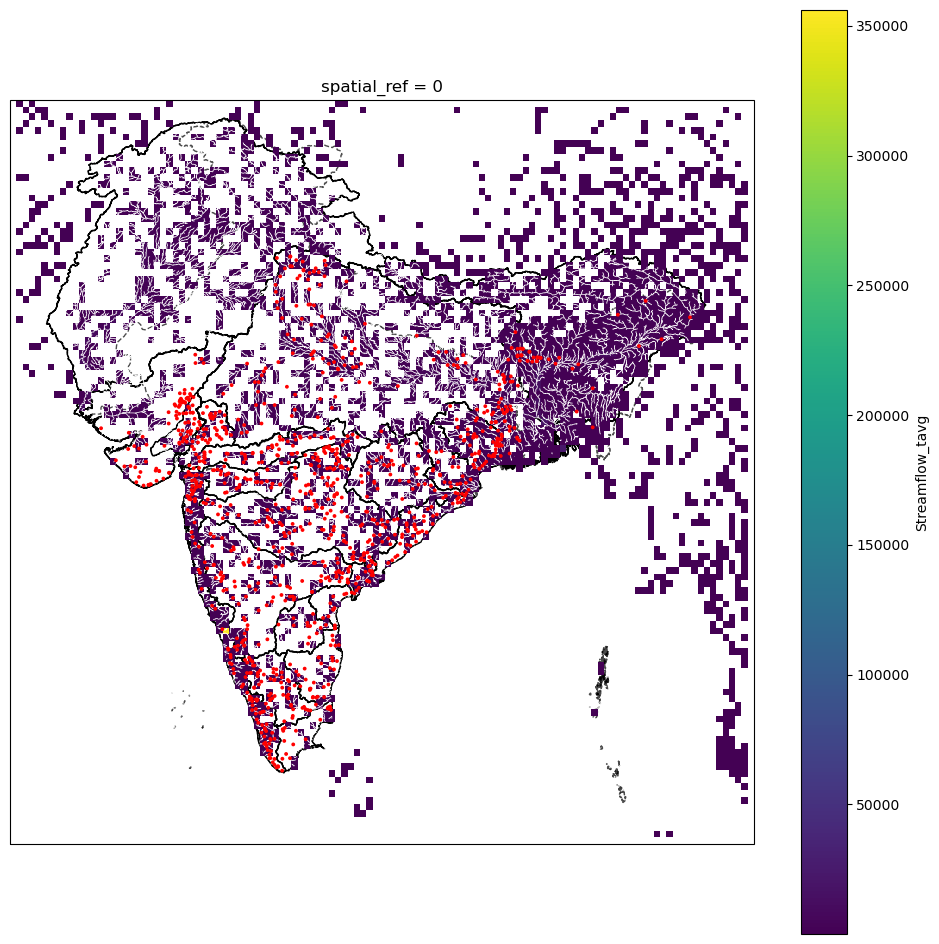

In [18]:
data1=data['Streamflow_tavg']
#data1['Streamflow_tavg'].mean(dim='time').plot(vmin=0,vmax=1000)

condi=np.sum(data1<1,axis=0)>8000

fig, axs = plt.subplots(1,1,subplot_kw={'projection': ccrs.PlateCarree()},figsize=(12,12),constrained_layout=False)

#Adding feature maps
south_asia=gpd.read_file(r'3_Data\Data_p\3_Shapefiles\south_asia_p.shp')
riv_map = gpd.read_file('3_Data/DATA_r/3_shapefiles_new/India_streams/India_stream.shp')
ind_map=gpd.read_file('3_Data/DATA_r/3_shapefiles_new/india_admin/Country/India_country.shp')
guage_info=pd.read_csv(r"3_Data\Data_r\2_Station\metadata.csv")

south_asia.plot(ax=axs,color = 'none',edgecolor = 'Black',linewidth=1,alpha=1)
ind_map.plot(ax=axs,color = 'none',linestyle='--',alpha=0.7,linewidth=1)
riv_map.plot(ax=axs,color = 'white',alpha=1,linewidth=0.5)

c1=np.repeat(['red'],len(guage_info['Latitude']))
axs.scatter(guage_info['Longitude'],guage_info['Latitude'],c=c1,s=3,zorder=4)

data2['Streamflow_tavg'].mean(dim='time').plot(ax=axs)

## 2_Streamflow Index


In [46]:
#1 Select a grid point where there is continous streamflow value

lat=data['lat'].values
lon=data['lon'].values
data_yr=data['Streamflow_tavg'].sel(time=data['time.month'].isin([6,7,8])).mean(dim='time')


ind=np.where(data_yr>10000)
ls=list(zip(*ind))
lat1=lat[ind[0]]
lon1=lon[ind[1]]

k=2
print(f'lat:{lat1[k]},lon:{lon1[k]}')
data['Streamflow_tavg'].sel(lat=lat1[k],lon=lon1[k],time=data['time.month'].isin([6,7,8])).mean(dim='time')


#val_a=a[ind];val_b=b[ind];val_c=c[ind]
#list(zip(*ind,val_a,val_b,val_c))
#pd.DataFrame(list(zip(*ind,val_a,val_b,val_c)),columns=['time','lon','lat','Qs','PPT','RE'])

lat:23.649982452392578,lon:90.04961395263672


<xarray.DataArray 'Streamflow_tavg' ()> Size: 8B
array(32121.42270268)
Coordinates:
    lat          float64 8B 23.65
    lon          float64 8B 90.05
    spatial_ref  int64 8B 0

In [82]:
## Season
ssn=['Pre-monsoon','Monsoon','Post-monsoon','Winter']
ssn_n=[[3,4,5],[6,7,8,9],[10,11],[12,1,2]]
ds_drt=[];ds_fld=[]

data1=sorted(glob.glob(f'3_Data/Data_r/1_ILDAS/*.nc*'))
data = xr.open_mfdataset(data1, combine='by_coords',engine='netcdf4', parallel=True,chunks={'time': 'auto'})
data = data.sel(lon=data['lon'][::3],lat=data['lat'][::3],time=slice('1975','2022'))
data = data.chunk({'time': -1})
for s in tqdm(range(4)):

    ## drt
    drt_ssn=data['Streamflow_tavg'].sel(time=data["time.month"].isin(ssn_n[s])).rolling(time=7).mean().resample(time='YE').min().compute()
    drt_ssn=drt_ssn.expand_dims(season=[ssn[s]])
    ds_drt.append(drt_ssn)

    ## Flood
    fld_ssn=data['Streamflow_tavg'].sel(time=data["time.month"].isin(ssn_n[s])).resample(time='YE').quantile(0.95, dim='time').compute()
    fld_ssn=fld_ssn.expand_dims(season=[ssn[s]])
    ds_fld.append(fld_ssn)

    
drt=xr.concat(ds_drt,dim='season').drop(['spatial_ref'])
fld=xr.concat(ds_fld,dim='season').drop(['quantile'])

dry_wet_ssn = xr.Dataset({'drt_flow': drt, 'fld_flow': fld})
dry_wet_ssn.to_netcdf(r'3_Data/Data_p/1_ILDAS/ILDAS_indices2.nc')



c:\Users\sstar\anaconda3\envs\imed\Lib\site-packages\xarray\core\indexing.py:1436: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
  0%|          | 0/4 [00:00<?, ?it/s]c:\Users\sstar\anaconda3\envs\imed\Lib\site-packages\dask\array\reductions.py:540: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
c:\Users\sstar\anaconda3\envs\imed\Lib\site-packages\numpy\lib\nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
 25%|██▌       | 1/4 [02:42<08:07, 162.62s/it]c:\Users\sstar\anaconda3\envs\i

In [77]:
#dry_wet_ssn['fld_flow'].sel(lat=lat1[k],lon=lon1[k],season='Monsoon').compute()

dry_wet_ssn['fld_flow'].sel(lat=lat1[k],lon=lon1[k],season='Pre-monsoon')

<xarray.DataArray 'fld_flow' (time: 48)> Size: 384B
array([104830.55625   ,  79645.2328125 , 106290.35546875,  92491.63867187,
        77043.31757813,  86206.33789062,  58682.55429687,  71939.86835937,
        55969.2078125 ,  84716.33828125,  52739.99824219,  50009.87441406,
        70476.11601562,  88633.2984375 ,  37871.33222656,  52670.43828125,
        61487.4625    ,  32262.02089844,  37468.20371094,  44439.16757813,
        45382.1109375 ,  49646.52558594,  40738.38222656,  65853.82167969,
        60393.42929687,  54658.92167969,  53467.10859375,  47423.87988281,
        56518.4234375 ,  67490.88476562,  59861.24472656,  41252.95664062,
        62966.95019531,  73134.9671875 ,  46966.38964844,  52963.98710937,
        62775.75859375,  45886.175     ,  80699.3203125 ,  68754.4296875 ,
        72525.62695312,  78090.99335938,  82457.65703125,  66183.91855469,
        72432.6921875 ,  84939.490625  ,  83436.05039062,  56511.8109375 ])
Coordinates:
    season   <U11 44B 'Pre-monsoon'
    lat      float64 8B 23.65
    lon      float64 8B 90.05
  * time     (time) datetime64[ns] 384B 1975-12-31 1976-12-31 ... 2022-12-31